In [1]:
import rockpool
print(f'Rockpool version {rockpool.__version__}')

import samna
print(f'Samna version {samna.__version__}')

# from rockpool.devices.xylo.syns63300 import mapper
from rockpool.devices.xylo.syns65302 import XyloSamna, config_from_specification, mapper, XyloSim, XyloSamnaPDM
from rockpool.devices.xylo.syns65302 import xylo_a3_devkit_utils as hdkutils
from rockpool.devices.xylo.syns65302.afe import PDM_SAMPLING_RATE

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize

from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np
import matplotlib.pyplot as plt

import time

from tqdm.autonotebook import tqdm

/usr/lib/python3/dist-packages/pythran/tables.py:4520: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, method):
/usr/lib/python3/dist-packages/pythran/tables.py:4553: FutureWarning: In the future `np.bytes` will be defined as the corresponding NumPy scalar.
  obj = getattr(themodule, elem)


Rockpool version 2.8.0.dev
Samna version 0.39.0.0
from samna.xyloA3.configuration import InputInterfaceConfig


In [2]:
hdks, modules, versions = find_xylo_hdks()

for version, xylo in zip(versions, hdks):
    if version == "syns65302":
        xa3_node = xylo

The connected Xylo HDK contains a Xylo A3. Importing `rockpool.devices.xylo.syns65302`


In [3]:
net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),
    Linear((63, 32)),
    LIF(32),
)
net

ModSequential  with shape (16, 32) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 32)
    LIF '3_LIF' with shape (32, 32)
}

In [4]:
net[0].weight *= 0.05

In [5]:
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

print(config)

WARNING    /home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_mapper.py:56: DRCWarning: Xylo-A3 only supports up to 16 output channels. The network requires 32 output channels.
  warnings.warn(
 [py.warnings]
  warnings.warn(



xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, input_source=InputSource.Adc, bias_enable=1, time_resolution_wrap=0, enable_hibernation_mode=0, hibernation_mode_time_resolution_wrap=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ -97 -123 71 100 31 -106 117 29 -127 -80 -25 -127 95 -112 -15 -98 110 121 -88 71 -114 -100 -52 98 86 -127 -85 48 -11 13 64 -103 -127 -17 -80 35 66 121 44 -90 -121 -78 -101 93 126 17 -16 -28 110 43 -58 -64 127 25 -19 -46 2 85 -86 98 118 -39 127 -46 103 -21 -60 66 -1 0 116 96 62 25 -68 -5 76 -91 -21 -21 76 -122 -115 49 -100 -118 -107 -127 32 119 57 -11 -127 -80 119 -110 -113 -106 -56 96 -64 95 -99 -89 122 45 -100 -51 -16 -48 118 93 95 105 -59 110 49 -86 120 20 -91 57 -26 -9 110 85 2 59 -41 -36 -57 117 -121 120 97 100 121 22 29 3 45 104 9 23 -83 -36 17 -73 -30 -6 76 106 -89 -21 -47 92 95 -19 -31 -83 81 55 -29 33 -47 -127 117 -8 -46 -79 -30 -23 -78 -52 -127 124 34 127 75 -32 43 78 39 -124 -53 51 -95 74

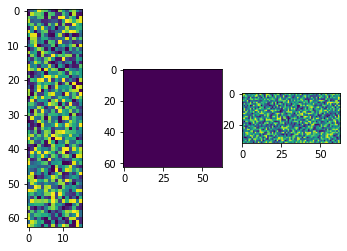

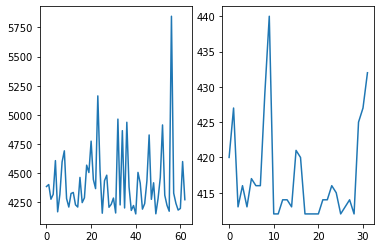

In [6]:
plt.subplot(1, 3, 1)
plt.imshow(np.array(config.input.weights).T)
plt.subplot(1, 3, 2)
plt.imshow(np.array(config.hidden.weights).T)
plt.subplot(1, 3, 3)
plt.imshow(np.array(config.readout.weights).T)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(spec['threshold'])
plt.subplot(1, 2, 2)
plt.plot(spec['threshold_out'])


In [7]:
# - Create a Xylo module with PDM input
dn = True
config.operation_mode = samna.xyloAudio3.OperationMode.AcceleratedTime
xmod = XyloSamnaPDM(xa3_node, config, dt=1024e-6, dn_active = dn)

In [8]:
print(config)

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.AcceleratedTime, input_source=InputSource.Pdm, bias_enable=1, time_resolution_wrap=0, enable_hibernation_mode=0, hibernation_mode_time_resolution_wrap=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ -97 -123 71 100 31 -106 117 29 -127 -80 -25 -127 95 -112 -15 -98 110 121 -88 71 -114 -100 -52 98 86 -127 -85 48 -11 13 64 -103 -127 -17 -80 35 66 121 44 -90 -121 -78 -101 93 126 17 -16 -28 110 43 -58 -64 127 25 -19 -46 2 85 -86 98 118 -39 127 -46 103 -21 -60 66 -1 0 116 96 62 25 -68 -5 76 -91 -21 -21 76 -122 -115 49 -100 -118 -107 -127 32 119 57 -11 -127 -80 119 -110 -113 -106 -56 96 -64 95 -99 -89 122 45 -100 -51 -16 -48 118 93 95 105 -59 110 49 -86 120 20 -91 57 -26 -9 110 85 2 59 -41 -36 -57 117 -121 120 97 100 121 22 29 3 45 104 9 23 -83 -36 17 -73 -30 -6 76 106 -89 -21 -47 92 95 -19 -31 -83 81 55 -29 33 -47 -127 117 -8 -46 -79 -30 -23 -78 -52 -127 124 34 127 75 -32 43 78 39 -124 -53 

In [9]:
# - Encode a PDM input chirp
from rockpool.devices.xylo.syns65302 import AFESimPDM

from scipy.signal import chirp

pdm_sr = PDM_SAMPLING_RATE
net_dt = 1024e-6
audio_sr = PDM_SAMPLING_RATE # 48e3

afesim_pdm = AFESimPDM.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    # spike_gen_mode="threshold",
    # fixed_threshold_vec = [2**25 for i in range(16)],
    rate_scale_factor=63,
    low_pass_averaging_window=84e-3,
    dn_EPS=1,
    fixed_threshold_vec=None,
    dt=net_dt,
)


# afesim_pdm = AFESimPDM.from_specification(
#     select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
#     # spike_gen_mode="divisive_norm",
#     spike_gen_mode="threshold",
#     fixed_threshold_vec = [2**25 for i in range(16)],
#     rate_scale_factor=63,
#     low_pass_averaging_window=84e-3,
#     dn_EPS=1,
#     # fixed_threshold_vec=None,
#     dt=net_dt,
# )

dur = 200e-3
# dur = 1000e-3

T = int(audio_sr * dur)
f_start = 1000
f_end = 20e3
times = np.arange(0, T) / audio_sr
signal = chirp(times, f_start, T/audio_sr, f_end, method='linear', phi = 90)
# signal = np.sin(2 * np.pi * f_start * times)

__scale = 0.95
out_pdm, state_pdm, rec_pdm = afesim_pdm((signal * __scale, audio_sr))

`dn_rate_scale_bitshift` = (6, 0) is obtained given the target `rate_scale_factor` = 63, with diff = 0.000000e+00
`dn_low_pass_bitshift` = 12 is obtained given the target `low_pass_averaging_window` = 0.084, with diff = 1.139200e-04
`down_sampling_factor` = 50 is obtained given the target `dt` = 0.001024, with diff = 0.000000e+00


WARNING    /tmp/ipykernel_17420/727471033.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,4,i+1)
 [py.warnings]
  plt.subplot(4,4,i+1)



(9774, 16)


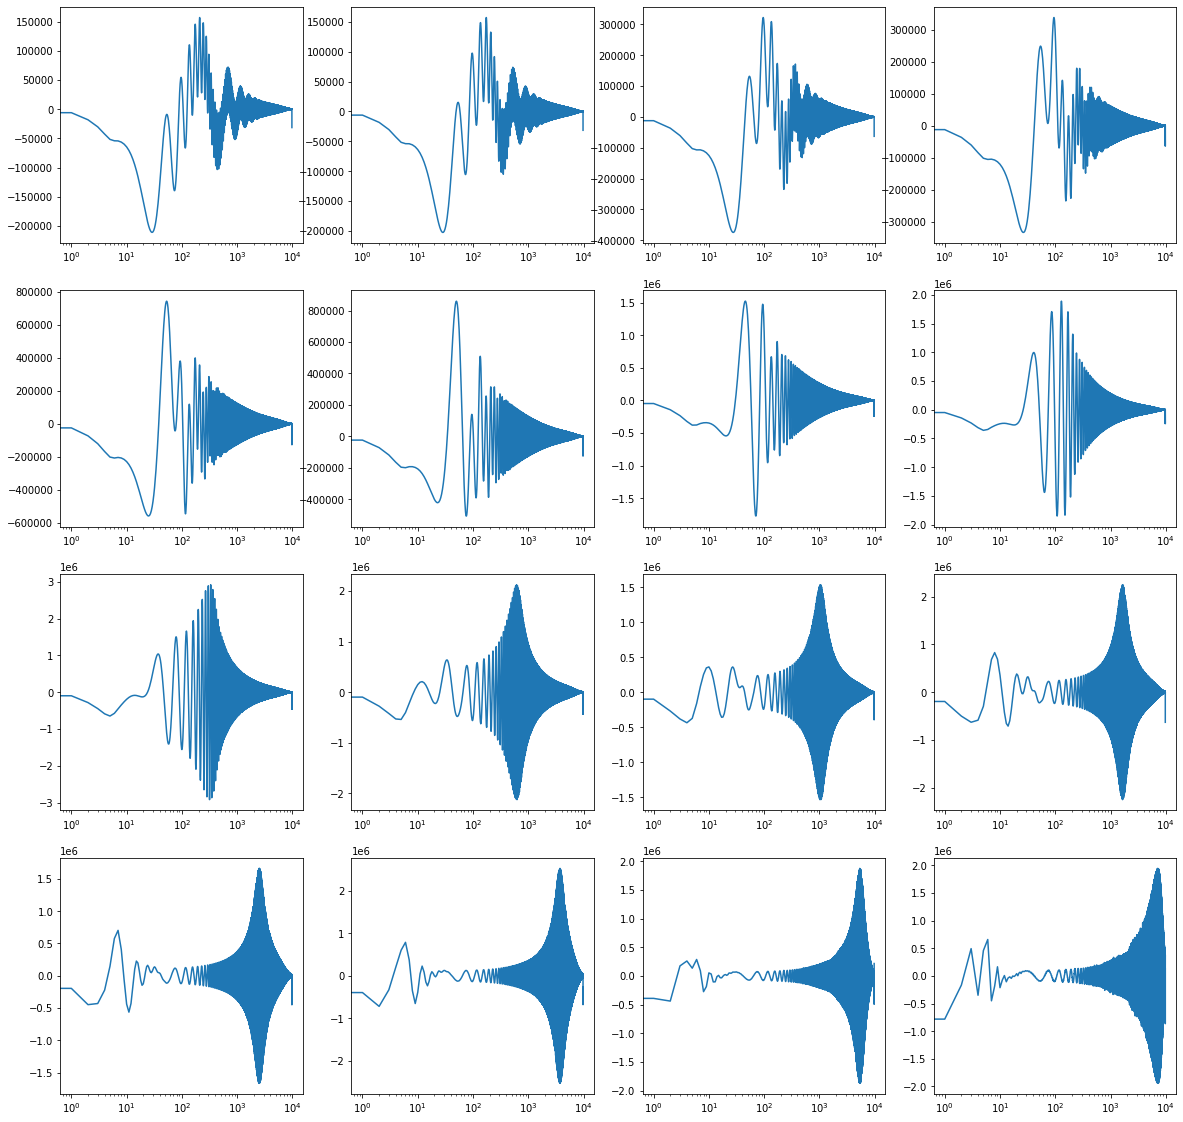

In [10]:
rec_pdm.keys()
filter_out = rec_pdm['1_ChipButterworth_output']
filter_in = rec_pdm['0_PDMADC_output']
plt.figure(figsize=(20, 20))
np.savetxt('filter_in.txt', filter_in, fmt = '%10d')
np.savetxt('filter_out.txt', filter_out, fmt='%10d')
plt.plot(filter_in)
plt.plot(filter_out); plt.legend(np.arange(16))
print(np.shape(filter_out))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.semilogx(filter_out[:,i])
# np.shape(rec_pdm['1_ChipButterworth_output'])
# rec_pdm['2_DivisiveNormalization']
# np.shape(rec_pdm['0_PDMADC_output'])

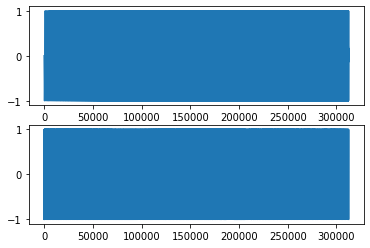

In [11]:
plt.subplot(2, 1, 1)
plt.plot(signal)
plt.subplot(2, 1, 2)
plt.plot(rec_pdm['0_PDMADC']['0_MicrophonePDM_output'])

In [12]:
input_pdm = (rec_pdm['0_PDMADC']['0_MicrophonePDM_output'] + 1) / 2
out, _, rd = xmod(input_pdm, record = True)

WARNING    /home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_samna_pdm.py:226: UserWarning: Input PDM audio trace does not fit evenly into `dt`. Audio will be trimmed at the end of the sample. input size: 312500; PDM_samples_per_dt: 1600.
  warn(
 [py.warnings]
  warn(



  0%|          | 0/195 [00:00<?, ?it/s]

In [13]:
# np.savetxt('input_pdm.txt',input_pdm, fmt= '%d')

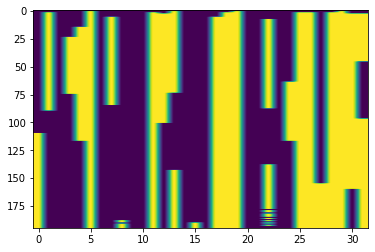

In [14]:
rd.keys()
np.shape(out)
plt.imshow(out, aspect = 'auto')

In [15]:
rd.keys()
print(np.shape(rd['Spikes_in']))

(195, 16)


In [16]:
# AFE_output = rd['Spikes_in']
# AFESim_output = rec_pdm['3_Raster_output']
# print(rec_pdm.keys())
dn_output = rec_pdm['2_DivisiveNormalization_output']

np.savetxt('dn_out_bin.txt', dn_output, fmt='%5d')
# dn_out = dn_output @ np.array([2**i for i in range(16)])

# np.savetxt('dn_out.txt', dn_out, fmt='%04x')
# print(dn_out)
# print(np.shape(dn_out))

# print(np.shape(rec_pdm['2_DivisiveNormalization_output']))
# np.savetxt('AFE_output.txt', AFE_output, fmt='%6d')
# np.savetxt('AFESim_output.txt', AFESim_output, fmt='%6d')

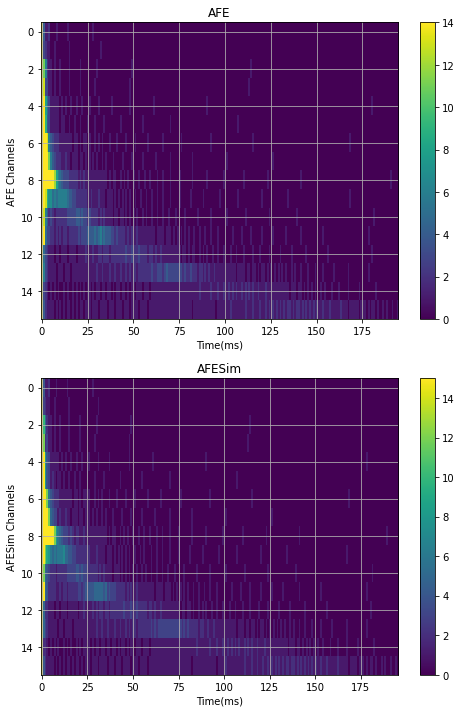

In [17]:
plt.figure(figsize=(8,12))
plt.subplot(211)
plt.imshow(rd['Spikes_in'].T, aspect = 'auto', interpolation='none'); plt.colorbar();  plt.grid(True)
plt.xlabel('Time(ms)'); plt.ylabel('AFE Channels')
plt.title('AFE')
plt.clim([0,14]);


plt.subplot(212)
plt.imshow(rec_pdm['3_Raster_output'].T, aspect ='auto', interpolation='none'); plt.colorbar();  plt.grid(True)
# plt.clim([0,3]);
plt.xlabel('Time(ms)'); plt.ylabel('AFESim Channels')
plt.title('AFESim')
plt.savefig('figs/' + 'dur='+str(dur).replace('.', '_') + 'With_DN_Chirp_afe_vs_afeSim_modified.png')


[ 130.  125.  205.  205.  310.  310.  510.  580.  990.  885.  690. 1015.
  740. 1065.  780. 1030.]
[ 130.  125.  215.  215.  315.  315.  515.  580.  990.  890.  700. 1015.
  745. 1070.  785. 1030.]
[0.0, 0.0, 0.04878048780487805, 0.04878048780487805, 0.016129032258064516, 0.016129032258064516, 0.00980392156862745, 0.0, 0.0, 0.005649717514124294, 0.014492753623188406, 0.0, 0.006756756756756757, 0.004694835680751174, 0.00641025641025641, 0.0]


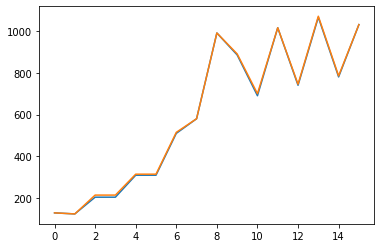

In [18]:
### for AFESim
a = np.sum(rec_pdm['3_Raster_output'].T, axis=1)/dur
print(a)

### for AFE
b = np.sum(rd['Spikes_in'].T, axis=1)/dur
print(b)

plt.plot(a)
plt.plot(b)

print([abs(i-j)/i for i,j in zip(a,b)])